In [40]:
# %%
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation
from scipy.stats import bernoulli
from svgpathtools import svg2paths
from svgpath2mpl import parse_path
# matplotlib parameters to ensure correctness of Chinese characters 
plt.rcParams["font.family"] = 'sans-serif'
plt.rcParams['font.sans-serif']=['Arial Unicode MS', 'SimHei'] # Chinese font
plt.rcParams['axes.unicode_minus']=False # correct minus sign

plt.rcParams["font.size"] = 20
plt.rcParams["xtick.labelsize"] = 24
plt.rcParams["ytick.labelsize"] = 24

In [41]:
np.random.seed(1901)
xx, yy = np.meshgrid(np.arange(100), np.arange(100)) #(100,100)
indices = np.random.choice(np.arange(100000), 5, replace=False) #从给定的1维数组中随机采样的函数
mask = np.zeros(100000).astype(bool)
# mask[indices] = True 
# fig, ax = plt.subplots(1,1, figsize=(10,10), dpi=150)
# ax.scatter(xx.flatten()[mask],yy.flatten()[mask],  s=40, color='k', marker='x' )
# ax.scatter(xx.flatten()[~mask],yy.flatten()[~mask],s=20, color='k', )
# ax.set_xlim(-1,100)
# ax.set_ylim(-1,100)
# %%
rvar = np.random.rand(mask.shape[0])
test_res = np.zeros_like(mask)
for i in range(mask.shape[0]):
    test_res[i] = rvar[i] >= 0.9995 # 索赔车辆
test_res[77]=True
test_res[333]=True
sum(test_res==True)

55

In [42]:
def gen_marker(fname):
    person_path, attributes = svg2paths(fname)
    person_marker = parse_path(attributes[0]['d'])
    person_marker.vertices -= person_marker.vertices.mean(axis=0)
    person_marker = person_marker.transformed(mpl.transforms.Affine2D().rotate_deg(180))
    person_marker = person_marker.transformed(mpl.transforms.Affine2D().scale(-1,1))
    return person_marker

car_marker = gen_marker('figures/car.svg')

(-0.15000000000000002, 3.15, -0.15000000000000002, 3.15)

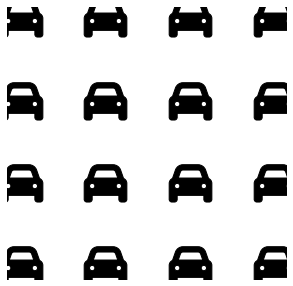

In [43]:
xx, yy = np.meshgrid(np.arange(4), np.arange(4))
fig, ax = plt.subplots(1,1, figsize=(5,5))
ax.scatter(xx.flatten(),yy.flatten(),  s=2000, color='k', marker=car_marker )
ax.axis('off')

In [69]:
class UpdateDist:
    def __init__(self, ax0, ax, ax1, patient_mask):
        self.success = 0

        self.ax0 = ax0
        xn, yn = 40, 10
        xx, yy = np.meshgrid(np.arange(xn), np.arange(yn))
        # indices = np.random.choice(np.arange(int(xn*yn)), int(xn*yn/100), replace=False)
        self.mask_plt = patient_mask[:int(xn*yn)]
        #self.sc_patient = ax0.scatter(xx.flatten()[self.mask_plt],yy.flatten()[self.mask_plt],  s=2000, facecolor=[1,0,0,1], marker=patient_marker)
        self.sc_car  = ax0.scatter(xx.flatten()[~self.mask_plt],yy.flatten()[~self.mask_plt],s=2000, facecolor=[0,32./255,96./255,1], marker=car_marker)
        self.color = np.tile([0,32./255,96./255,1],(int(xn*yn),1))
        self.color[self.mask_plt,:] = [1,0,0,1]
        self.ax0.set_xlim(-1,xn)
        self.ax0.set_ylim(-1,yn)
        self.ax0.invert_yaxis()
        
        
        self.rects = ax.barh([1,2], [0,0], ) #条形图
        for rec, color in zip(self.rects, ( [228./255,131./255,18./255,1], [0,176./255,80./255,1] )):
            rec.set_color(color)
                 
        self.ax = ax
        self.ax.set_yticks([1,2])
        self.ax.set_yticklabels(["", ""])
        self.ax.set_xlabel("投保车辆数对数"+r'$log_{10}(x)$', fontsize=30)
        # self.ax.set_yticklabels(["检测阳性新冠患者","检测阳性健康人群", "检测阴性"], fontsize=20)
        # self.ax.text(-0.130, 0.17, "新冠患者", transform=self.ax.transAxes, fontsize=25, color='r', )
        # self.ax.text(-0.130, 0.27, "检测阳性", transform=self.ax.transAxes, fontsize=25, color=[228./255,131./255,18./255,1], )
        # self.ax.text(-0.130, 0.43, "健康人群", transform=self.ax.transAxes, fontsize=25, color=[0,32./255,96./255,1], )
        self.ax.text(-0.170, 0.21, "索赔车辆数", transform=self.ax.transAxes, fontsize=25, color=[228./255,131./255,18./255,1], )
        self.ax.text(-0.190, 0.47, "未索赔车辆数", transform=self.ax.transAxes, fontsize=25, color=[0,176./255,80./255,1], )
        # self.ax.set_yticklabels(["True Positive","False Positive", "Negative"], fontsize=20)
        # self.ax.set_xlabel("Number of people", fontsize=20)

        # Set up plot parameters
        self.ax.set_ylim(0, 4)
        self.ax.set_xlim(0, 6)
        self.ax.spines['top'].set_visible(False)
        self.ax.spines['right'].set_visible(False)

        self.line, =ax1.plot([],[])
        self.ax1 = ax1
        self.ax1.set_xlim([0,100000])
        self.ax1.set_ylim([-200,200])
        self.ax1.set_ylabel("盈利金额", fontsize=25) 
        self.ax1.set_xlabel("投保车辆", fontsize=30)
        # self.ax1.set_xlabel('Number of people tested', fontsize=20)
        # self.ax1.set_ylabel('Test accuracy', fontsize=20)
        self.ax1.spines['top'].set_visible(False)
        self.ax1.spines['right'].set_visible(False)
        #self.ax1.axhline(175.0, linestyle='--', color='black')#0.01*0.9/(0.01*0.9+0.99*0.09)=0.0917

        # This vertical line represents the theoretical value, to
        # which the plotted distribution should converge.

    def __call__(self, i):
        # This way the plot can continuously run and we just keep
        # watching new realizations of the process
        if i == 0:
            self.success = 0
            for rect, h in zip(self.rects, [0,0]): 
                rect.set_width(h)
            self.line, = self.ax1.plot([], [], lw=5, color='r')
            return self.rects

        # Choose success based on exceed a threshold with a uniform pick
        # if np.random.rand(1,) < self.prob:
        #     self.success += 1
        # y = beta_pdf(self.x, self.success + 1, (i - self.success) + 1)
        # self.line.set_data(self.x, y)

        if i <= 100:
            self.ax.set_xlim([0,6])
            n_inc = 4
            # update histogram
            negative = np.sum(~test_res[:n_inc*(i+1)]) #未索赔车辆数
            positive = np.sum(test_res[:n_inc*(i+1)]) #索赔车辆数
            for rect, h in zip(self.rects, [math.log(positive+1,10),math.log(negative+1,10)]): 
                rect.set_width(h)
            # update curve
            self.ax1.set_xlim([0,500])
            self.ax1.set_ylim([-50000,100000])
            self.ax1.plot([0,500], [0,175*500], lw=3, ls="--",color='black')
            xdata, ydata = self.line.get_data()
            if len(xdata) == 0:
                xdata = [0]
                ydata = [(negative*200.0-50000.0*positive)]
            else:
                xdata = np.append(xdata, xdata[-1]+n_inc) 
                ydata = np.append(ydata,(negative*200.0-50000.0*positive) ) 
            self.line.set_data(xdata, ydata)
        else:
            self.ax.set_xlim([0,6])
            self.ax1.set_xlim([0,100000])
            self.ax1.set_ylim([0,200*1000*i])
            self.ax1.plot([0,100000], [0,175*100000], lw=3, ls="--",color='black')
            n_inc = 1000
            # update histogram
            negative = np.sum(~test_res[:401+n_inc*(i-99)])
            positive = np.sum(test_res[:401+n_inc*(i-99)])
            for rect, h in zip(self.rects, [math.log(positive,10),math.log(negative,10)]): 
                rect.set_width(h)
            # update curve
            xdata, ydata = self.line.get_data()
            xdata = np.append(xdata, xdata[-1]+n_inc) 
            ydata = np.append(ydata, (negative*200.0-50000.0*positive)) 
            self.line.set_data(xdata, ydata)
        # update scatter facecolor
        if i <= 100:
            n_inc = 4
            for j in range(n_inc):
                # idx = i-1
                idx = (i-1)*n_inc+j
                self.color[idx,:] = [228./255,131./255,18./255,1] if test_res[idx] else [0,176./255,80./255,1]
            self.sc_car.set_facecolor(self.color)
        return self.rects

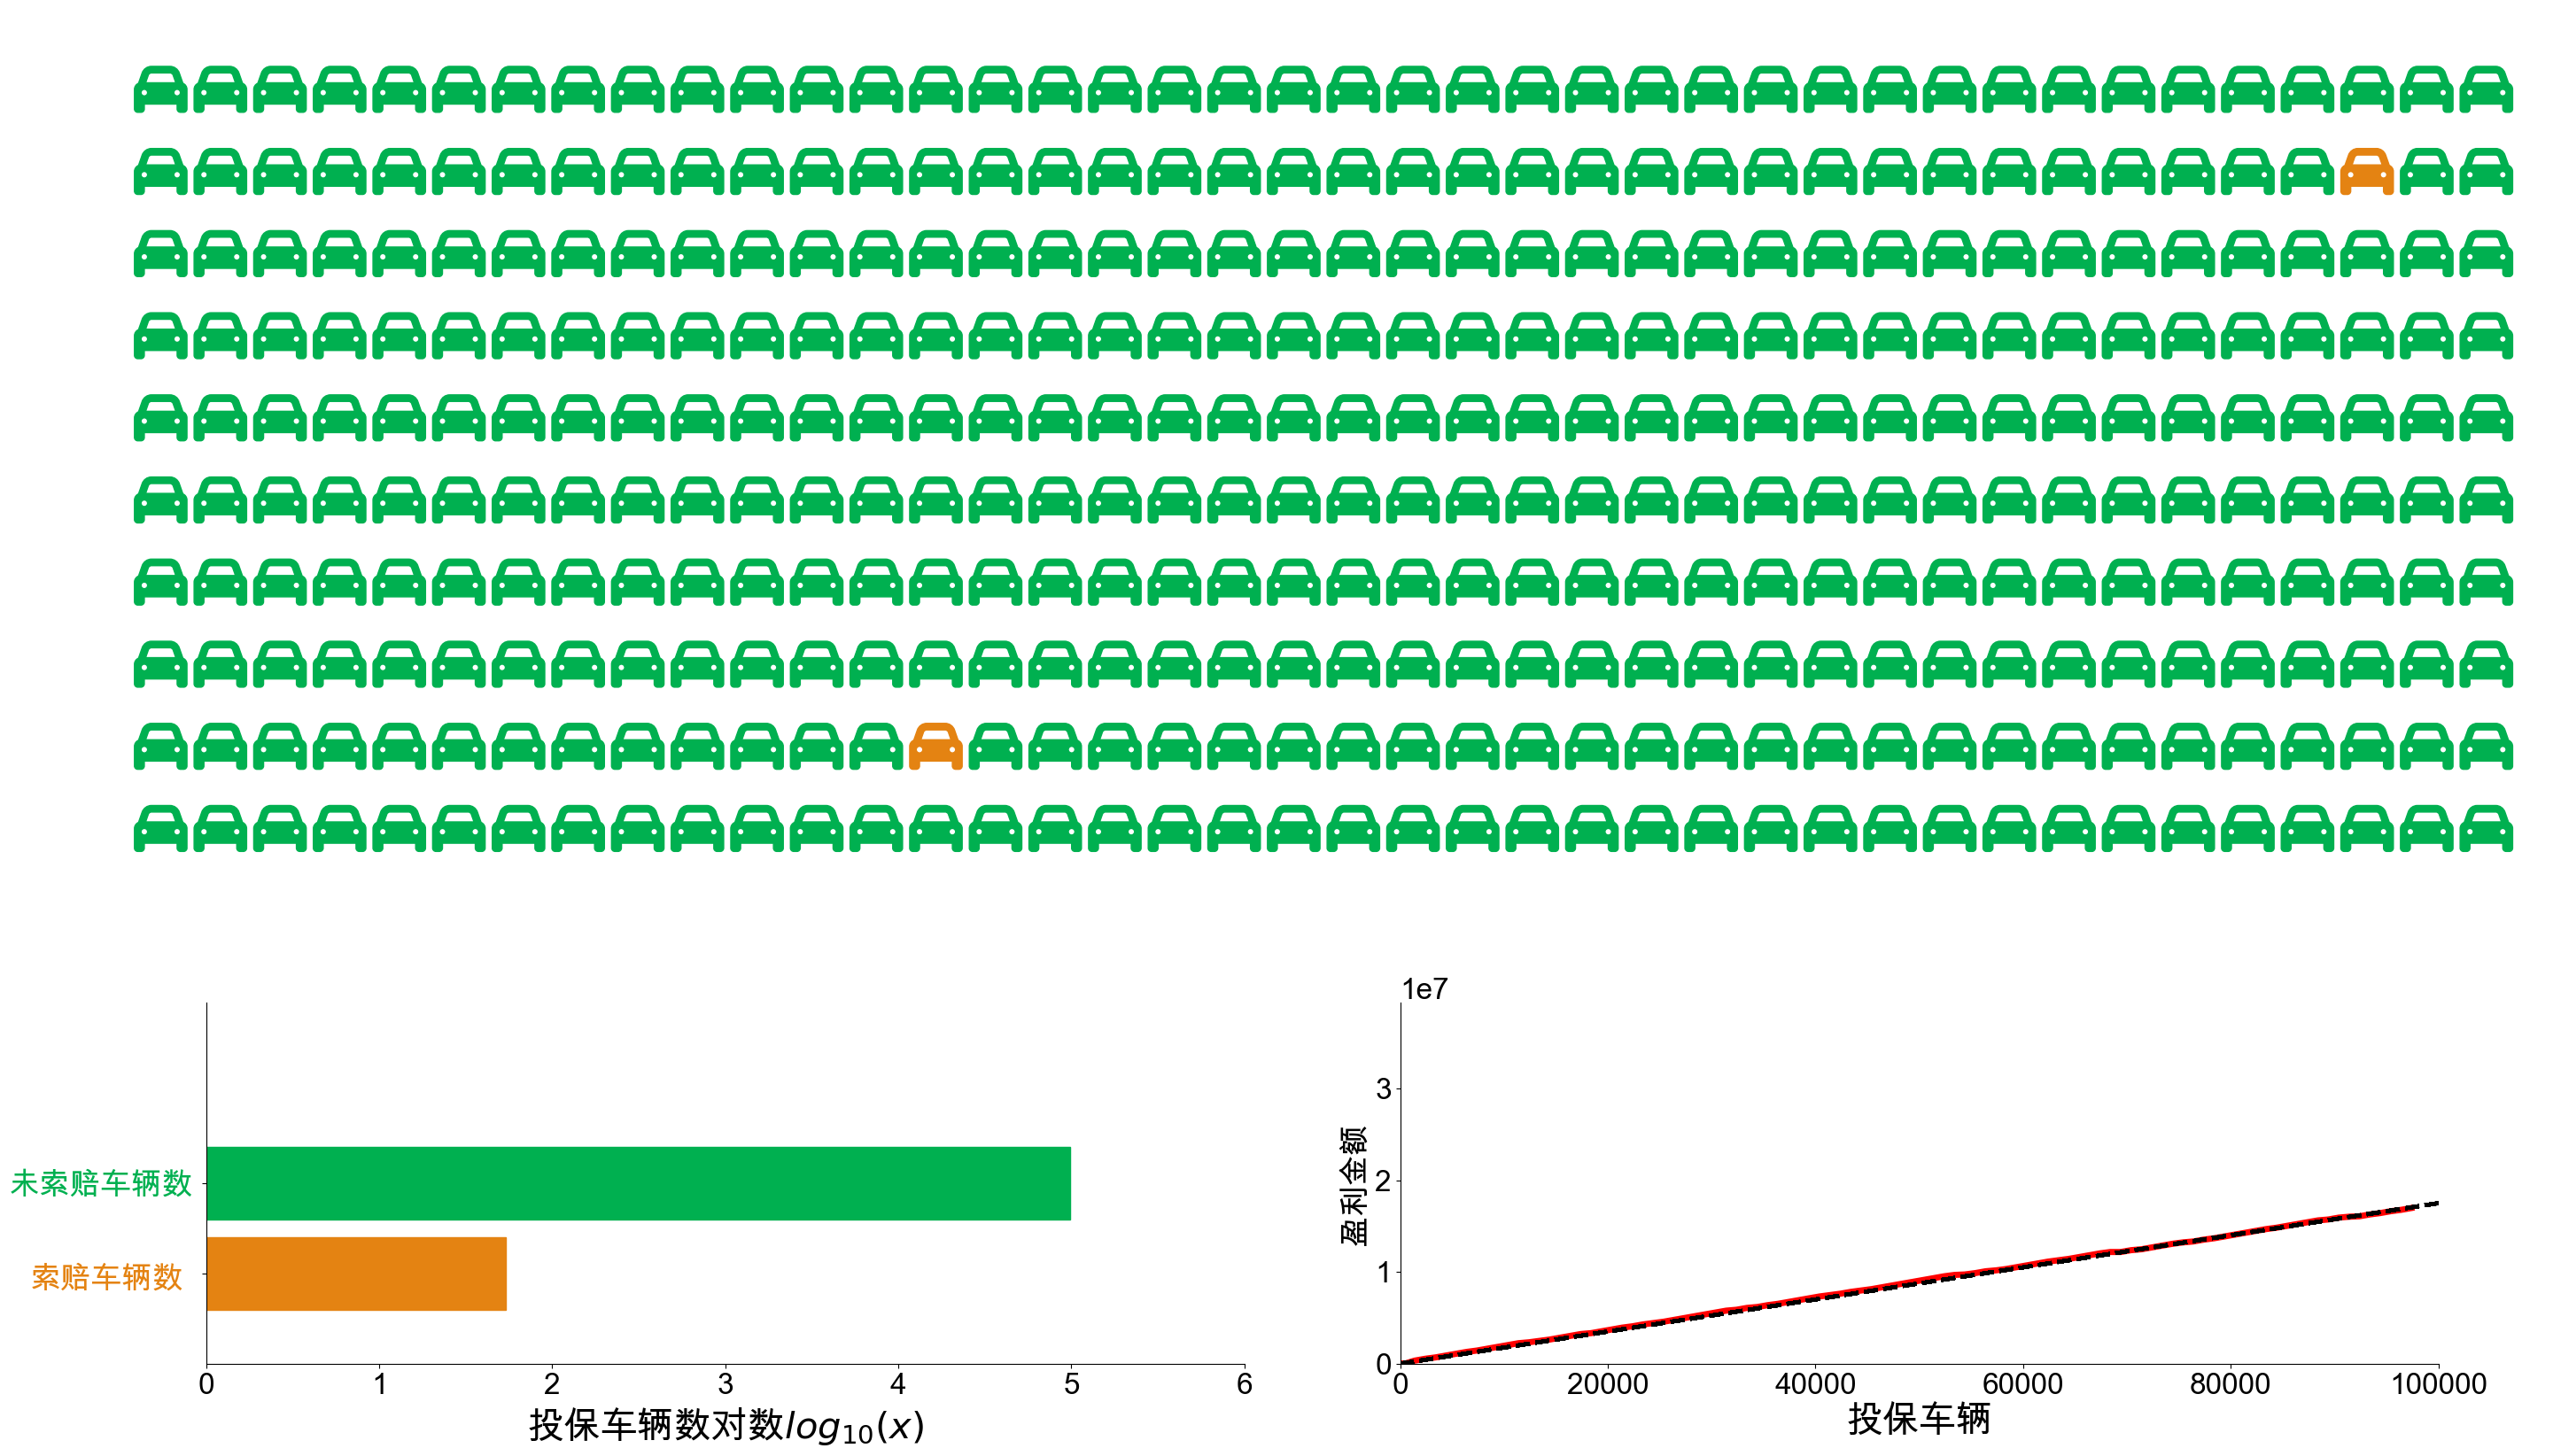

In [70]:
fig = plt.figure(figsize=(30,17),dpi=100)
spec1 = gridspec.GridSpec(ncols=1, nrows=1, left=0.04, right=0.96, top=0.98, bottom=0.38, figure=fig)
ax0 = fig.add_subplot(spec1[0])
ax0.axis('off')
spec2 = gridspec.GridSpec(ncols=2, nrows=1, left=0.08, right=0.92, top=0.32, bottom=0.08, wspace=0.15, figure=fig)
ax1 = fig.add_subplot(spec2[0])
ax2 = fig.add_subplot(spec2[1])
ud = UpdateDist(ax0, ax1, ax2, mask)
anim = FuncAnimation(fig, ud, frames=198, blit=True)
anim.save('car_movie3.mp4', fps=10, dpi=200, codec='libx264', bitrate=-1, extra_args=['-pix_fmt', 'yuv420p'])